## Un échantillon de galaxies proches sur la séquence principale dans l’hémisphère nord


Il n'est pas nécessaire d'exécuter toutes les parties du code.
La partie Sélection des distances nécéssite le fichier Dist.xml pour fonctionner.
Les parties calculatoires du SFR et de la masse stellaire nécessitent l'import de 2 Go de fichier fits depuis le site https://irsa.ipac.caltech.edu/data/WISE/z0MGS/ en utilisant le fichier catalog.dat produit par le code.
Le tableau final des valeurs a été extrait, il s'agit du fichier donnees.dat qui peut directement être utilisé dans la partie "Exploitation des données obtenues". 

### Imports

In [114]:
#Basics

import numpy as np
import math
import os
import glob
from io import BytesIO
import requests
print(os.getcwd())


#Astropy
from astropy.table import Table
from astropy.table import Column
from astropy.io.votable import parse_single_table
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.utils.data import download_file

#Astroquery
from astroquery.ipac.ned import Ned

#Plotting

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LogNorm



e:\Jupiter_Notebook_PIR


Fonctions générales

In [115]:
def statistics(name) :
    print('-------------------------------------------------------------------------------------------')
    print('mean=', np.mean(name))
    print('median=',np.median(name))
    print('standard deviation=',np.std(name))
    print('-1 sigma=',np.median(name) - np.percentile(name, 15.8))
    print('1 sigma=', np.percentile(name, 84.5) - np.median(name))
    print('-------------------------------------------------------------------------------------------')

## Un premier échantillon

Dans un premier temps, on veut extraire un premier échantillon brut de galaxies, en utilisant les premiers critères "observationnels" tirés de [Leroy et al., 2021]

- Distance < 20 Mpc
- 25 degrés < Inclinaison < 75 degrés
- Visible par Noema, donc -25 degrés < déclinaison < 90 degrés (la déclinaison doit être comprise entre 0 et 90 degrés pour rester dans l'hémisphère Nord)

Pour convertir la distance en distance modulus (mod), on utilise la formule : 

mod=5log(Distance)+25

Ainsi : mod0 < 31.80863918

Pour étendre ce critère, on utilise aussi modbest qui prend la valeur moyenne de mod0 et modz.

### Extraction des données d'hyperleda par requête SQL : 

In [116]:
#url via HyperLeda, critère : objtype='G', mod0<31.80863918, 25<incl<75, de2000>0
url_1 ='http://atlas.obs-hp.fr/hyperleda/fG.cgi?n=meandata&c=o&of=1,leda,simbad&nra=l&nakd=1&d=objname%2Cmod0%2Cal2000%2Cde2000&sql=objtype%3D%27G%27%20and%20mod0<31.80863918%20and%20incl>25%20and%20incl<75%20and%20de2000>0&ob=al2000&a=htab'

#Import the Table from url
t_1=Table.read(url_1, format="html")

#url via HyperLeda, critère : objtype='G', modbest<31.80863918, 25<incl<75, de2000>0
url_2 ='http://atlas.obs-hp.fr/hyperleda/fG.cgi?n=meandata&c=o&of=1,leda,simbad&nra=l&nakd=1&d=objname%2Cmodbest%2Cal2000%2Cde2000&sql=objtype%3D%27G%27%20and%20modbest<31.80863918%20and%20incl>25%20and%20incl<75%20and%20de2000>0&ob=al2000&a=htab'

#Import the Table from url
t_2=Table.read(url_2, format="html")

On visualise ainsi un premier échantillon de galaxies : 

C:\Users\valen\AppData\Local\Temp\ipykernel_6348\3738842448.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax.plot(t_1['al2000']*2*np.pi/24,10**((t_1['mod0']-25)/5),"r.",  color= 'mediumaquamarine', label= 'Samples for mod0')
C:\Users\valen\AppData\Local\Temp\ipykernel_6348\3738842448.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax.plot(t_2['al2000']*2*np.pi/24,10**((t_2['modbest']-25)/5),"r.",  color= 'salmon', label= 'Samples for modbest', alpha=0.6)


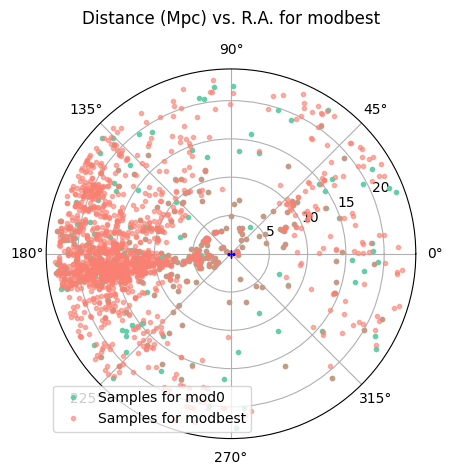

In [117]:
#plot polar axis
fig,ax=plt.subplots(subplot_kw={'projection': 'polar'})

#plot Table values
#arg1 : hours to degree / arg2 : mag to Mpc

ax.plot(t_1['al2000']*2*np.pi/24,10**((t_1['mod0']-25)/5),"r.",  color= 'mediumaquamarine', label= 'Samples for mod0')
ax.plot(0,0,"b+")
ax.set_title('Distance (Mpc) vs. R.A. for mod0',loc='center',y=1.1)

ax.plot(t_2['al2000']*2*np.pi/24,10**((t_2['modbest']-25)/5),"r.",  color= 'salmon', label= 'Samples for modbest', alpha=0.6)
ax.plot(0,0,"b+")
ax.set_title('Distance (Mpc) vs. R.A. for modbest',loc='center',y=1.1)
ax.legend(loc='lower left')

## Sélection des distances

En utilisant différentes méthodes de mesure pour les distances, on arrive à réduire drastiquement cet échantillon 

### Fonctions utiles :

In [118]:
#Remplacement d'une colonne
def dist_col_replace(t,mod=str):
    distance=[]
    for i in range(0,len(t)):
        if np.float32(t[mod][i]) == 0:
            x=0
        else:
            x=10**((np.float32(t[mod][i])-25)/5)
        distance.append(x)
    t[mod]=distance

### Extraction depuis Hyperleda : 

In [119]:
#url via HyperLeda, critères : objtype='G', mod0<31.80863918, 25<incl<75, de2000>0
url = 'http://atlas.obs-hp.fr/hyperleda/fG.cgi?n=meandata&c=o&of=1,leda,simbad&nra=l&nakd=1&d=pgc%2Cobjname%2Cmod0%2Cmodbest%2Cal2000%2Cde2000%2Cincl%2Cvrot%2Ce_mod0%2Clogd25&sql=objtype%3D%27G%27%20and%20modbest<31.80863918%20and%20incl>25%20and%20incl<75%20and%20de2000>0&ob=&a=htab'

#Import de la table depuis l'url
t=Table.read(url, format="html")

Depuis le tableau de galaxies obtenus, on doit effectuer quelques modifications : 

In [120]:
#On renomme al2000 = ra et de2000 = dec

t['al2000'].name = 'RA'
t['de2000'].name = 'DEC'

In [121]:
#On retire les galaxies qui ne sont pas NGC ou qui n'ont pas de Vrot

for i in range(len(t)-1,-1,-1):
    if t['objname'][i][0]!='N' :
        t.remove_row(i)

t['vrot'].fill_value = -99
for i in range(len(t)-1,-1,-1):
    if t.filled()['vrot'][i]<0:
        t.remove_row(i)

t['mod0'].fill_value = -99
for i in range(len(t)-1,-1,-1):
    if t.filled()['mod0'][i]<0:
        t.remove_row(i)




In [122]:
#On limite la masse des galaxies à 2* le Grand Nuage de Magellan (https://arxiv.org/pdf/astro-ph/0006018 + Tully-Fisher)
for i in range(len(t)-1,-1,-1):
    if t['vrot'][i]<80*2**(1/4):
        t.remove_row(i)

In [123]:
#Diamètre des galaxies, logd25 [log(0.1arcmin)] -> degré
diameter=[]
for i in range(0,len(t)):
    x=10**(t['logd25'][i])/600
    diameter.append(x)
t.add_column(diameter,name='diameter')




In [124]:
#On retire la galaxie d'Andromède qui représente énormément de données et prend trop de place sur le ciel

for i in range(len(t)-1,-1,-1):
    if t['diameter'][i]==np.max(t['diameter']):
        t.remove_row(i)

t.remove_column('logd25')



In [125]:
# Ajout d'une colonne de distance
distance=[]
for i in range(0,len(t)):
    x=10**((t['mod0'][i]-25)/5)
    distance.append(x)
t.add_column(distance,name='distance')


In [126]:
#Importation des données d'extinctions
Ext=Table.read("Tab_Extinction.dat",format='ascii')
Ext.keep_columns(['objname','AV_SandF'])
t.add_column(Ext['AV_SandF'],name='Extinction')

# Ajout d'une colonne de distance avec extinction
d_with_extinction=[]
for i in range(0,len(t)):
    d_with_extinction.append(10**((t['mod0'][i]-25-t['Extinction'][i])/5))

t.add_column(d_with_extinction,name='Distance+Extinction')
t.remove_column('Extinction')

In [127]:
#Différentes références de distance : Temps approximatif d'exécution : 2 minutes

votable = parse_single_table("Dist.xml") #Ce fichier est essentiel pour exécuter le code
ref = Table.read(votable)

ref['LEDA.PGC_ID'].name = 'pgc'
ref['.DM'].name = 'mod'
ref['.eDM'].name = 'mod_err'
ref['.DMsnIa'].name = 'snI'
ref['.eDMsn1'].name = 'snI_err'
ref['.DMtf'].name = 'Tully Fisher'
ref['.eDMtf'].name = 'Tully Fisher_err'
ref['.DMtrgb'].name = 'TRGB'
ref['.eDMt'].name = 'TRGB_err'
ref['.DMcep'].name = 'Cepheid'
ref['.eDMcep'].name = 'Cepheid_err'

ref_pgc=[]
ref_dist=[]
ref_err=[]
ref_snI=[]
ref_snI_err=[]
ref_TF=[]
ref_TF_err=[]
ref_TRGB=[]
ref_TRGB_err=[]
ref_cep=[]
ref_cep_err=[]

for i in range(0,len(t)):
    for j in range(0,len(ref)):
        if ref['pgc'][j]==t['pgc'][i]:
            ref_pgc.append(t['objname'][i])
            ref_dist.append(ref['mod'][j])
            ref_err.append(ref['mod_err'][j])
            ref_snI.append(ref['snI'][j])
            ref_snI_err.append(ref['snI_err'][j])
            ref_TF.append(ref['Tully Fisher'][j])
            ref_TF_err.append(ref['Tully Fisher_err'][j])
            ref_TRGB.append(ref['TRGB'][j])
            ref_TRGB_err.append(ref['TRGB_err'][j])
            ref_cep.append(ref['Cepheid'][j])
            ref_cep_err.append(ref['Cepheid_err'][j])
            
arr=np.array(list(zip(ref_pgc,ref_dist,ref_err,ref_snI,ref_snI_err,ref_TF,ref_TF_err,ref_TRGB,ref_TRGB_err,ref_cep,ref_cep_err)))
ref_tab=Table(arr,names=('objname','distance','distance_err','snI','snI_err','Tully Fisher','Tully Fisher_err','TRGB','TRGB_err','Cepheid','Cepheid_err'))

dist_col_replace(ref_tab,'distance')
dist_col_replace(ref_tab,'distance_err')
dist_col_replace(ref_tab,'snI')
dist_col_replace(ref_tab,'snI_err')
dist_col_replace(ref_tab,'Tully Fisher')
dist_col_replace(ref_tab,'Tully Fisher_err')
dist_col_replace(ref_tab,'TRGB')
dist_col_replace(ref_tab,'TRGB_err')
dist_col_replace(ref_tab,'Cepheid')
dist_col_replace(ref_tab,'Cepheid_err')




In [128]:
#On retire les galaxies qui n'ont pas de référence

cpt=0
for i in range(0,len(ref_tab)):
    if ref_tab['objname'][i]!=t['objname'][i-cpt]:
        t.remove_row(i-cpt)

#Remove Galaxies if no references

In [129]:
#Ordre de priorité : Supernovae type I , Tip of Red Giant Branch, Cepheid, Tully Fisher/Mean

dist_ref=[]
err_ref=[]
type_ref=[]
for i in range(0,len(ref_tab)):
    x=ref_tab['Cepheid'][i]
    y=ref_tab['snI'][i]
    z=ref_tab['TRGB'][i]
    d=ref_tab['distance'][i]
    if x!=0:
        y=0
        z=0
        d=0
        val=x
        e=ref_tab['Cepheid_err'][i]
        typ='Cepheid'
    if y!=0:
        z=0
        d=0
        val=y
        e=ref_tab['snI_err'][i]
        typ='snI'
    if z!=0:
        d=0
        val=z
        e=ref_tab['TRGB_err'][i]
        typ='TRGB'
    if d!=0:
        val=d
        e=ref_tab['distance_err'][i]
        typ='Tully Fisher'
    dist_ref.append(val)
    err_ref.append(e)
    type_ref.append(typ)

t.add_column(dist_ref,name='distance reference')
t.add_column(err_ref,name='distance reference error')
t.add_column(type_ref,name='Reference type')



In [130]:
#On retire les galaxies qui présentent des incohérences


for i in range(len(t)-1,-1,-1):
    if np.abs(t['distance reference'][i]-t['Distance+Extinction'][i]) > 0.1*t['Distance+Extinction'][i] and np.abs(t['distance reference'][i]-t['distance'][i]) > 0.1*t['distance'][i] :
        t.remove_row(i)

#t.remove_column('pgc')
t.remove_column('modbest')
t.remove_column('e_mod0')
t.remove_column('mod0')
t.remove_column('distance reference error')


On obtient alors un nouvel échantillon de galaxies

### Export et affichage des données

In [131]:
# Export des données
ascii.write(t, 'catalogue.dat', overwrite=True)
print("Number of Galaxies in the catalogue:",len(t),"\n")
#print(ref_tab,'\n')
print('\n############################\n')
print(t,'\n')

Number of Galaxies in the catalogue: 80 


############################

 pgc  objname     RA     ... distance reference Reference type
----- ------- ---------- ... ------------------ --------------
37132 NGC3930 11.8627348 ... 12.094836235046387   Tully Fisher
40342 NGC4356  12.404061 ... 16.165897369384766   Tully Fisher
51846 NGC5645 14.5109317 ... 15.017577171325684   Tully Fisher
35676 NGC3726 11.5558806 ...  13.20079517364502   Tully Fisher
36875 NGC3893 11.8106075 ... 16.390792846679688   Tully Fisher
37290 NGC3949 11.8949228 ...  17.97215461730957   Tully Fisher
38392 NGC4102 12.1065433 ... 18.475662231445312   Tully Fisher
 1160 NGC0063  0.2959778 ... 18.247356414794922   Tully Fisher
41934 NGC4548 12.5906909 ...  15.98820972442627        Cepheid
42168 NGC4579 12.6287586 ... 19.186697006225586   Tully Fisher
  ...     ...        ... ...                ...            ...
26341 NGC2787  9.3217874 ...   7.38924503326416   Tully Fisher
42734 NGC4636 12.7137976 ... 14.6285066604614

C:\Users\valen\AppData\Local\Temp\ipykernel_6348\2812107643.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax.plot(t['RA']*2*np.pi/24,t['distance'],"r.", color = 'salmon')


Text(0.0, 1.1, 'Distance (Mpc) vs. R.A.')

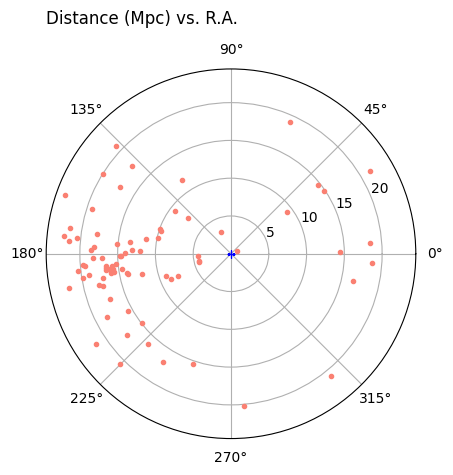

In [132]:
# Graphe polaire

#plot polar axis
fig,ax=plt.subplots(subplot_kw={'projection': 'polar'})

#plot Table values
#arg1 : hours to degree / arg2 : mag to Mpc

ax.plot(t['RA']*2*np.pi/24,t['distance'],"r.", color = 'salmon')
ax.plot(0,0,"b+")
ax.set_title('Distance (Mpc) vs. R.A.',loc='left',y=1.1)
#plt.savefig("Celestial_Position.png")

Statistiques pour la distance
-------------------------------------------------------------------------------------------
mean= 15.475019211532764
median= 16.50848409080325
standard deviation= 4.820462422144131
-1 sigma= 6.629179722254785
1 sigma= 3.679046454102693
-------------------------------------------------------------------------------------------
Statistiques pour inclinaison
-------------------------------------------------------------------------------------------
mean= 57.5125
median= 59.535
standard deviation= 11.906120747329922
-1 sigma= 16.79954
1 sigma= 9.576999999999998
-------------------------------------------------------------------------------------------
Statistiques la vitesse de rotation
-------------------------------------------------------------------------------------------
mean= 158.72199999999998
median= 147.28
standard deviation= 54.724957569650066
-1 sigma= 35.34528
1 sigma= 55.54929999999999
-------------------------------------------------------------

c:\Users\valen\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\valen\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


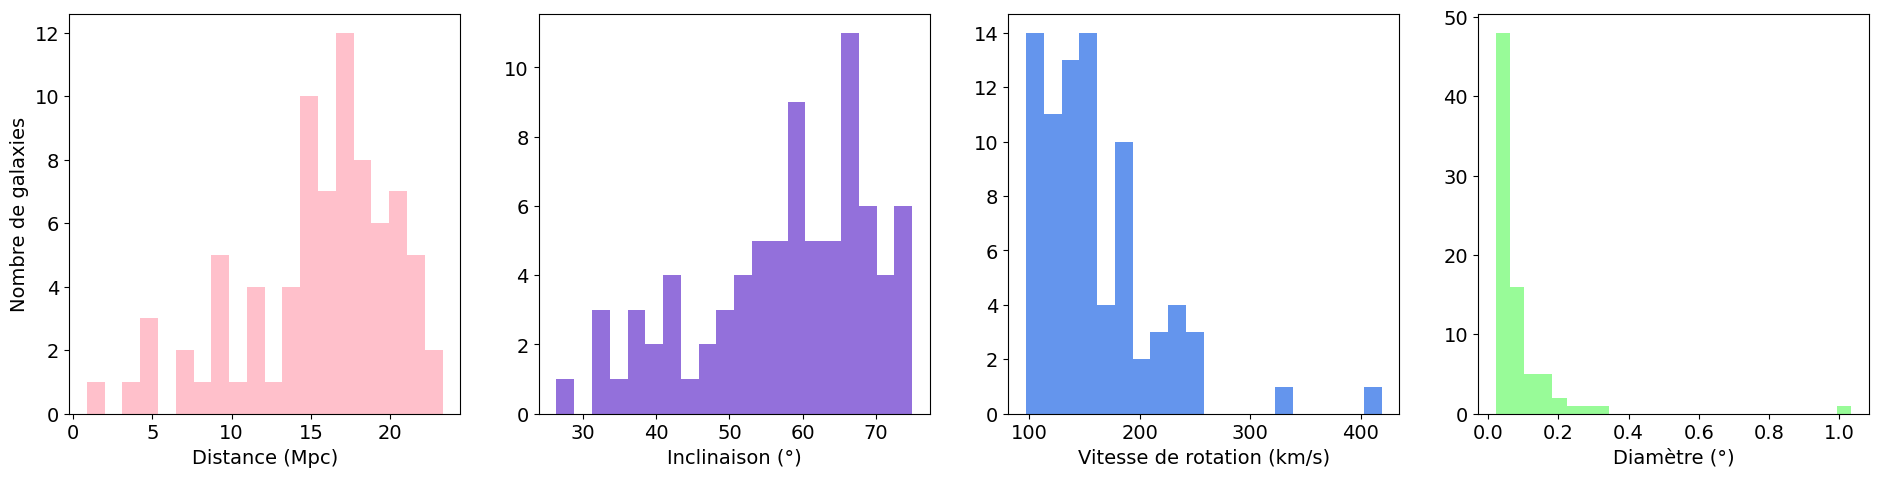

In [133]:
plt.figure(figsize = (10, 5)) 
matplotlib.rcParams.update({'font.size': 14})

plt.subplot(1,4,1)
plt.hist(t['distance'],color='pink',ec='black',bins=20)
plt.xlabel('Distance (Mpc)')
plt.ylabel('Nombre de galaxies')

print('Statistiques pour la distance')
statistics(t['distance'])

plt.subplot(1,4,2)
plt.hist(t['incl'],color='mediumpurple',ec='black',bins=20)
plt.xlabel('Inclinaison (°)')

print('Statistiques pour inclinaison')
statistics(t['incl'])


plt.subplot(1,4,3)
plt.hist(t['vrot'],color='cornflowerblue',ec='black',bins=20)
plt.xlabel('Vitesse de rotation (km/s)')

print('Statistiques la vitesse de rotation')
statistics(t['vrot'])

plt.subplot(1,4,4)
plt.hist((t['diameter']), color='palegreen',ec='black',bins=25)
plt.xlabel('Diamètre (°)')

print('Statistiques le diamètre')
statistics(t['diameter'])


plt.gcf().subplots_adjust(left = 0.2, bottom = 0.1, right = 2, top = 0.9, wspace = 0.2, hspace = 0.2)



## Masse stellaire et Star formation rate (SFR)

On cherche maintenant à inclure des critères de sélection sur la masse stellaire totale des galaxies et leur taux de formation stellaire (SFR). Dans un premier temps, il va falloir les calculer. On prend pour cela les formules données par [Leroy et al., 2019]

### Masse stellaire

In [134]:
def Stellar_Mass_function(intensity):
    upsilon_36=0.5 #msol/lsol
    result=3.3*(10**2)*(upsilon_36/0.5)*intensity #gives stellar mass in Solar Masses per parsec ^2
    return result

### Taux de formation stellaire

In [135]:
#Relation SFR (1)
#SFR determined by C-O Luminosity
def SFR_1(WISE,Lv):
    if (WISE==3):
        C = 10**-42.67                                       # Coefficient Kennicutt & Evans
    if (WISE==4):
        C = 10**-42.55                                       
    return (Lv*C)                                            # Lv = v.Lv here is the luminosity (in erg per second) 


#Relation ΣSFR (2) and (3)

#Method by integrated photometry
def SFR_density(band,Ium):                                        # ΣSFR (result in this function) is in Msolar per year per pc^2
    if (band == 'W3'):                                            # In this case, the frequency v corresponds to lambda = 12 micrometer
        C = 10**(-42.9)
        #C = 10**(-42.67)                                         # for better estimations, you can use this value of C (WISE 3)
        Coef = (3.77*(10**-3))/(10**-42.9)
        result = Coef*C*Ium                                       # Intensity Ium in MJy per sr
    if (band == 'W4'):                                            # In this case, the frequency v corresponds to lambda = 22 micrometer
        C = 10**(-42.7)
        #C = 10**(-42.55)                                         # for better estimations, you can use this value of C (WISE 4)
        Coef = (3.24*(10**-3))/(10**-42.7)
        result = Coef*Ium*C                                                            
    if (band == 'NUV'):                                            # In this case, the frequency v corresponds to lambda = 22 micrometer
        C = 10**(-43.17)
        #C = 10**(−43.24)                                         # for better estimations, you can use this value of C (NUV)
        Coef = (1.05*(10**-1))/(10**-43.17) 
        result = Coef*Ium*C  
    if (band == 'FUV'):                                            # In this case, the frequency v corresponds to lambda = 22 micrometer
        C = 10**(-43.35)
        #C = 10**(-43.42)                                         # for better estimations, you can use this value of C (FUV)
        Coef = (1.04*(10**-1))/(10**-43.35)
        result = Coef*Ium*C  
    return result/10**6


### Fonction de conversion

In [136]:
### Conversion function
def pixel_conversion(distance, spectra):
    if 'CD1_1' not in spectra[0].header:
        CD1_1 = np.abs(spectra[0].header['CDELT1'])
    else:
        CD1_1 = np.abs(spectra[0].header['CD1_1'])
    
    dist_pc = distance*10**6 #converts distance in Mpc to distance in pc
    pixel_size_deg = abs(CD1_1)
    pixel_size_rad = np.deg2rad(pixel_size_deg) 
    pixel_size_pc = dist_pc * pixel_size_rad  
    return (pixel_size_pc ** 2)

### Fonction de masquage pour WISE 3

In [137]:
def Mask_W3(spectraa_W3, spectraa_W1):
    # make a new array that will become the mask for integrating the mass and SFR
    # initialise to NaNs
    galaxymask_W3_7p5=spectraa_W3[0].data*0.+np.nan
    # masque au dessus d'un palier W1/W3
    idx = np.where((spectraa_W3[0].data > 0.5) | (spectraa_W1[0].data > 0.2))
    galaxymask_W3_7p5[idx] = 1
    # on ajoute un masque circulaire par rapport à la distance depuis le centre de l'image (ici 60 pixels)
    w = WCS(spectraa_W3[0].header)
    naxis = w.pixel_shape
    ymat, xmat = np.indices((naxis[1], naxis[0]))
    w3x0=int(naxis[0]/2)
    w3y0=int(naxis[1]/2)
    dxmat=xmat-w3x0
    dymat=ymat-w3y0
    rmat=np.sqrt(dxmat*dxmat+dymat*dymat)
    idx = np.where(rmat > 60)
    galaxymask_W3_7p5[idx] = np.nan
    # multiplie l'image W1 par le masque
    masked_w1_true = spectraa_W1[0].data*galaxymask_W3_7p5
    return masked_w1_true


### Calculs de la masse stellaire et du taux de formation stellaire

In [138]:
SFR_W4=[]
SFR_NUV=[]
SFR_FUV=[]
Stellar_Mass = []

In [139]:
#Ouverture des fichiers depuis le répertoire courant

# Fichier FITS depuis WISE 1

filepath_W1 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w1_gauss7p5.fits'
filepath_W1_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w1_gauss7p5_stars.fits'

# Fichier FITS depuis WISE 3

filepath_W3 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss7p5.fits'
filepath_W3_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss7p5_stars.fits'

filepath_W3_15 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss15.fits'
filepath_W3_stars_15 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w3_gauss15_stars.fits'

# Fichier FITS depuis WISE 4

filepath_W4 = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w4_gauss15.fits'
filepath_W4_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_w4_gauss15_stars.fits'

# Fichier FITS depuis NUV

filepath_NUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_nuv_gauss15.fits'
path_NUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/'
filepath_NUV_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_nuv_gauss15_stars.fits'

# Fichier FITS depuis FUV

filepath_FUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_fuv_gauss7p5.fits'
path_FUV = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/'
filepath_FUV_stars = 'File_Sample/irsa.ipac.caltech.edu/data/WISE/z0MGS/images/PGCXXX/PGCXXX_fuv_gauss7p5_stars.fits'


In [140]:
for i in range(0,len(t)):
    key_NUV = 0
    key_FUV = 0
    this_filepath_W1 = filepath_W1.replace('XXX',str(t['pgc'][i]))
    this_filepath_W1_stars = filepath_W1_stars.replace('XXX',str(t['pgc'][i]))
    
    this_filepath_W3 = filepath_W3.replace('XXX',str(t['pgc'][i]))
    this_filepath_W3_stars = filepath_W3_stars.replace('XXX',str(t['pgc'][i]))
    
    this_filepath_W3_15 = filepath_W3_15.replace('XXX',str(t['pgc'][i]))
    this_filepath_W3_stars_15 = filepath_W3_stars_15.replace('XXX',str(t['pgc'][i]))
    
    this_filepath_W4 = filepath_W4.replace('XXX',str(t['pgc'][i]))
    this_filepath_W4_stars = filepath_W4_stars.replace('XXX',str(t['pgc'][i]))

    this_filepath_FUV = filepath_FUV.replace('XXX',str(t['pgc'][i]))
    this_path_FUV = path_FUV.replace('XXX',str(t['pgc'][i]))
    this_filepath_FUV_stars = filepath_FUV_stars.replace('XXX',str(t['pgc'][i]))

    this_filepath_NUV = filepath_NUV.replace('XXX',str(t['pgc'][i]))
    this_path_NUV = path_NUV.replace('XXX',str(t['pgc'][i]))
    this_filepath_NUV_stars = filepath_NUV_stars.replace('XXX',str(t['pgc'][i]))
    

    try:
        with fits.open(this_filepath_NUV) as NUV_hdu:
            key_NUV = 0  # File exists, set to 0
    except FileNotFoundError:
        key_NUV = 1  # File doesn't exist, set to 1

    try:
        with fits.open(this_filepath_FUV) as FUV_hdu:
            key_FUV = 0  # File exists, set to 0
    except FileNotFoundError:
        key_FUV = 1  # File doesn't exist, set to 1
    

    #Pour un échantillon donné, on traite tous les fichiers : 
    
    #WISE 1 ( pour le calcul de la masse stellaire)
    science_W1 = fits.open(this_filepath_W1)                            #Contient les données de la galaxie
    mask_W1 = fits.open(this_filepath_W1_stars)                         #Masque des étoiles qui se situent devant elle
    spectra_W1 = science_W1 + mask_W1                                   #Combine les deux pour obtenir le spectre final
    W1 = spectra_W1[0].data
    
    #WISE 3 7p5 resolution (pour appliquer le masquage)
    science_W3 = fits.open(this_filepath_W3)                           
    mask_W3 = fits.open(this_filepath_W3_stars)                       
    spectra_W3 = science_W3 + mask_W3  
    W3 = spectra_W3[0].data

    #WISE 3 15 resolution (pour appliquer le masquage)
    science_W3_15 = fits.open(this_filepath_W3_15)                           
    mask_W3_15 = fits.open(this_filepath_W3_stars_15)                       
    spectra_W3_15 = science_W3_15 + mask_W3_15
    W3_15 = spectra_W3_15[0].data  
    
    #WISE 4 (pour le calcul du SFR)
    science_W4 = fits.open(this_filepath_W4)                           
    mask_W4 = fits.open(this_filepath_W4_stars)                       
    spectra_W4 = science_W4 + mask_W4
    W4 = spectra_W4[0].data

    #Distance de la galaxie
    dist = t['distance'][i]
    dist_pc = dist*10**6

    #Application du masque
    
    masked_w1 = Mask_W3(spectra_W3,spectra_W1)
    masked_w4 = Mask_W3(spectra_W3_15,spectra_W4)
                       

    #Calculs de la masse stellaire et du SFR
    total_stellar_mass_masked = np.nansum(Stellar_Mass_function(masked_w1)*pixel_conversion(dist, spectra_W1))
    total_SFR_masked_W4 = np.nansum(SFR_density('W4',masked_w4)*pixel_conversion(dist, spectra_W4))
   
    if (key_FUV == 0):
    #FUV (pour le SFR)
        science_FUV = fits.open(this_filepath_FUV)                           
        mask_FUV = fits.open(this_filepath_FUV_stars)                       
        spectra_FUV = science_FUV + mask_FUV
        FUV = spectra_FUV[0].data
        
    #SFR FUV
        masked_fuv = Mask_W3(spectra_W3,spectra_FUV)
        total_SFR_masked_FUV = np.nansum(SFR_density('FUV',masked_fuv)*pixel_conversion(dist, spectra_FUV))
    
    if (key_FUV == 1):
        total_SFR_masked_FUV = np.nan

    if (key_NUV == 0):
    #NUV (for Star Formation Rate)
        science_NUV = fits.open(this_filepath_NUV)                           
        mask_NUV = fits.open(this_filepath_NUV_stars)                       
        spectra_NUV = science_NUV + mask_NUV
        NUV = spectra_NUV[0].data

    #SFR NUV
        masked_nuv = Mask_W3(spectra_W3_15,spectra_NUV)
        total_SFR_masked_NUV = np.nansum(SFR_density('NUV',masked_nuv)*pixel_conversion(dist, spectra_NUV))
    else:
        total_SFR_masked_NUV = np.nan

    
    SFR_W4.append(total_SFR_masked_W4)
    SFR_FUV.append(total_SFR_masked_FUV)
    SFR_NUV.append(total_SFR_masked_NUV)
    Stellar_Mass.append(total_stellar_mass_masked)

t.add_column(Stellar_Mass,name='Mass')
t.add_column(SFR_W4,name='SFR W4')
t.add_column(SFR_FUV,name='SFR FUV')
t.add_column(SFR_NUV,name='SFR NUV')


On a ainsi ajouté les colonnes masse stellaire et SFR à notre tableau. On en récupère un fichier .dat, c'est celui qu'on utilisera par la suite pour ne pas avoir à tout ré-exécuter

In [141]:
print(t)
ascii.write(t, 'donnees_tableau.dat', overwrite=True)

 pgc  objname     RA     ...        SFR FUV               SFR NUV       
----- ------- ---------- ... --------------------- ---------------------
37132 NGC3930 11.8627348 ...  0.004452907312266214 0.0011074680911020015
40342 NGC4356  12.404061 ... 0.0009089922857149263  0.007123019572543904
51846 NGC5645 14.5109317 ...   0.08078648470240123    0.1508431676269569
35676 NGC3726 11.5558806 ...    0.2434923831609258   0.34592216952048527
36875 NGC3893 11.8106075 ...   0.48120776230595647    0.8537377741384289
37290 NGC3949 11.8949228 ...    0.4794003293732842     0.721594299789377
38392 NGC4102 12.1065433 ...   0.06571739666850945   0.13630238410645154
 1160 NGC0063  0.2959778 ...   0.03265830553995578   0.07244563447021891
41934 NGC4548 12.5906909 ...   0.04967150438524818   0.08305743578178573
42168 NGC4579 12.6287586 ...   0.21146920000394293   0.39473312563712326
  ...     ...        ... ...                   ...                   ...
26341 NGC2787  9.3217874 ... 0.0015822055253693634 

## Exploitation des données obtenues

In [142]:
donnees = Table.read("donnees_tableau.dat", format='ascii')
print(donnees)

 pgc  objname     RA     ...        SFR FUV               SFR NUV       
----- ------- ---------- ... --------------------- ---------------------
37132 NGC3930 11.8627348 ...  0.004452907312266214 0.0011074680911020015
40342 NGC4356  12.404061 ... 0.0009089922857149263  0.007123019572543904
51846 NGC5645 14.5109317 ...   0.08078648470240123    0.1508431676269569
35676 NGC3726 11.5558806 ...    0.2434923831609258   0.34592216952048527
36875 NGC3893 11.8106075 ...   0.48120776230595647    0.8537377741384289
37290 NGC3949 11.8949228 ...    0.4794003293732842     0.721594299789377
38392 NGC4102 12.1065433 ...   0.06571739666850945   0.13630238410645154
 1160 NGC0063  0.2959778 ...   0.03265830553995578   0.07244563447021891
41934 NGC4548 12.5906909 ...   0.04967150438524818   0.08305743578178573
42168 NGC4579 12.6287586 ...   0.21146920000394293   0.39473312563712326
  ...     ...        ... ...                   ...                   ...
26341 NGC2787  9.3217874 ... 0.0015822055253693634 

### Interprétation des données obtenues

In [143]:
#Fonction qui crée un fit entre le SFR la Masse Stellaire, selon Speagle ea 2014
def Speagle_fit(mstar):
    t = 13.7                                                                # âge en gigannées de l'Univers pour le SFMS à z=0
    SFR = (0.84-0.026*t)*np.log10(mstar)-(6.51-0.11*t)                      # Fit de Speagle ea 2014
    return SFR

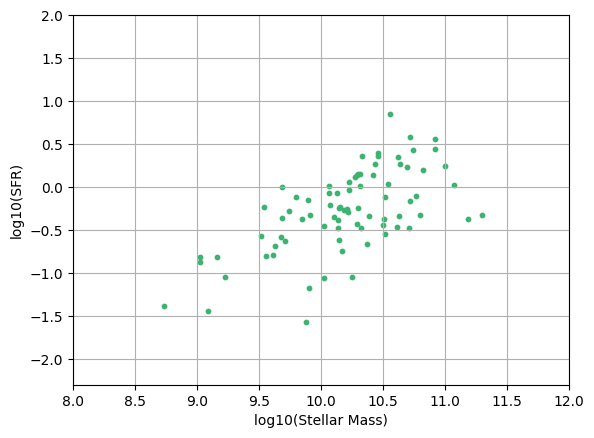

In [144]:
matplotlib.rcParams.update({'font.size': 10})
#Plot SFR / Stellar mass
plt.scatter(np.log10(donnees['Mass']),np.log10(donnees['SFR W4']),s=10, color='mediumseagreen')
plt.grid()
plt.ylabel("log10(SFR)")
plt.xlim(8,12)
plt.ylim(-2.3,2)
plt.xlabel("log10(Stellar Mass)")
plt.xlim(8,12)
plt.ylim(-2.3,2)
plt.show()

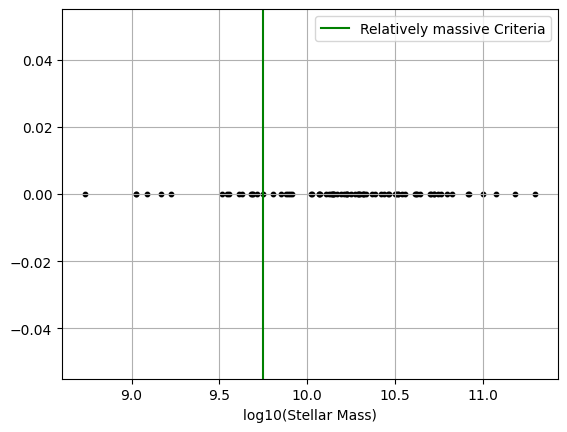

In [145]:
#Mass Criteria (plot in 1D)

plt.scatter(np.log10(donnees['Mass']),np.zeros(len(donnees)),s=10,color="black")
plt.axvline(x=9.75, color="green", label="Relatively massive Criteria")
plt.grid()
plt.xlabel("log10(Stellar Mass)")
plt.legend()
#The criteria is described according to Leroy et al 2021: log10(M*) > 9.75
plt.show()

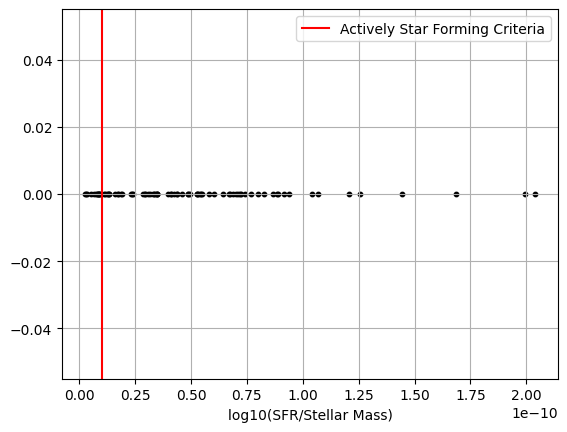

In [146]:
#The following criteria is described according to Leroy et al 2021: SFR/M* > 10**−11 yr**−1
Tab = ((donnees['SFR W4'])/(donnees['Mass']))
#(plot in 1D)
plt.scatter(Tab,np.zeros(len(donnees)),s=10,color="black")
plt.axvline(x=10**(-11), color="red", label="Actively Star Forming Criteria")
plt.grid()
plt.xlabel("log10(SFR/Stellar Mass)")
plt.legend()

In [147]:
# We reduce the list by removing galaxies that do not meet the Leroy 2021 criteria.
for i in range(len(donnees)-1,-1,-1):
    if (np.log10(donnees['Mass'][i])<=9.75)or(((donnees['SFR W4'][i])/(donnees['Mass'][i]))<=pow(10,-11)):
        donnees.remove_row(i)


print(donnees)
ascii.write(donnees, 'donnees_finales.dat', overwrite=True)
ascii.write(donnees, 'donnees_finales.csv', delimiter=',', overwrite=True)


 pgc  objname     RA     ...       SFR FUV              SFR NUV       
----- ------- ---------- ... -------------------- --------------------
35676 NGC3726 11.5558806 ...   0.2434923831609258  0.34592216952048527
36875 NGC3893 11.8106075 ...  0.48120776230595647   0.8537377741384289
37290 NGC3949 11.8949228 ...   0.4794003293732842    0.721594299789377
38392 NGC4102 12.1065433 ...  0.06571739666850945  0.13630238410645154
 1160 NGC0063  0.2959778 ...  0.03265830553995578  0.07244563447021891
41934 NGC4548 12.5906909 ...  0.04967150438524818  0.08305743578178573
42168 NGC4579 12.6287586 ...  0.21146920000394293  0.39473312563712326
44086 NGC4808 12.9302658 ...  0.17061117939928727  0.27223771544760456
38150 NGC4062 12.0677323 ...  0.07432942818557174  0.13422719275458744
53578 NGC5806 15.0001103 ...  0.09786077670282327  0.16787494232689748
  ...     ...        ... ...                  ...                  ...
43495 NGC4736 12.8480832 ...  0.11394658169833774  0.16864320757412204
46153 

In [148]:
donnees_finales = Table.read("donnees_finales.dat", format='ascii')
donnees_anciennes = Table.read("donnees_tableau.dat", format='ascii')


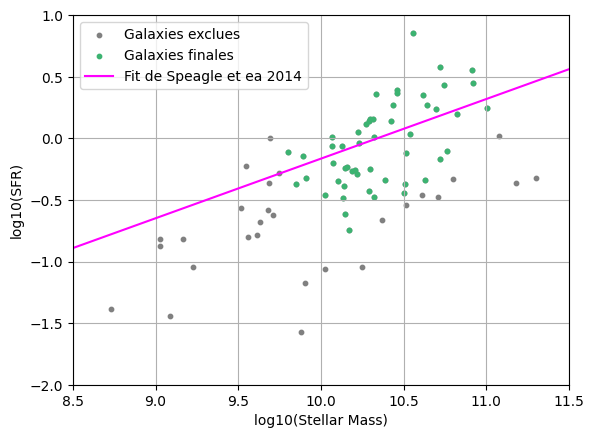

In [149]:
plt.scatter(np.log10(donnees_anciennes['Mass']),np.log10(donnees_anciennes['SFR W4']),s=10, color='grey', label = 'Galaxies exclues')
plt.scatter(np.log10(donnees_finales['Mass']),np.log10(donnees_finales['SFR W4']),s=10, color='mediumseagreen', label = 'Galaxies finales')

log10_mlim_left = 8.5
log10_mlim_right = 11.5
log10_SFR_theo = []
log10_mass_theo = np.linspace(log10_mlim_left,log10_mlim_right,1000)
for i in range(len(log10_mass_theo)):
    log10_SFR_theo.append(Speagle_fit(10**(log10_mass_theo[i])))



plt.plot(log10_mass_theo, log10_SFR_theo, color='magenta', label = 'Fit de Speagle et ea 2014')
plt.grid()
plt.ylabel("log10(SFR)")
plt.xlim(log10_mlim_left,log10_mlim_right)
plt.ylim(-2,1)
plt.xlabel("log10(Stellar Mass)")
plt.legend(loc='upper left')
plt.show()

### Statistiques des résultats obtenus

Statistiques pour la distance
-------------------------------------------------------------------------------------------
mean= 16.003923736420557
median= 16.804222389522604
standard deviation= 4.512381913438069
-1 sigma= 6.7846717073589975
1 sigma= 3.7501876305000224
-------------------------------------------------------------------------------------------
Statistiques pour inclinaison
-------------------------------------------------------------------------------------------
mean= 59.050384615384615
median= 60.14
standard deviation= 10.952327634859259
-1 sigma= 11.789500000000004
1 sigma= 9.14694999999999
-------------------------------------------------------------------------------------------
Statistiques la vitesse de rotation
-------------------------------------------------------------------------------------------
mean= 160.93576923076924
median= 151.4
standard deviation= 36.583181473403535
-1 sigma= 21.67666
1 sigma= 40.58064999999999
----------------------------------------

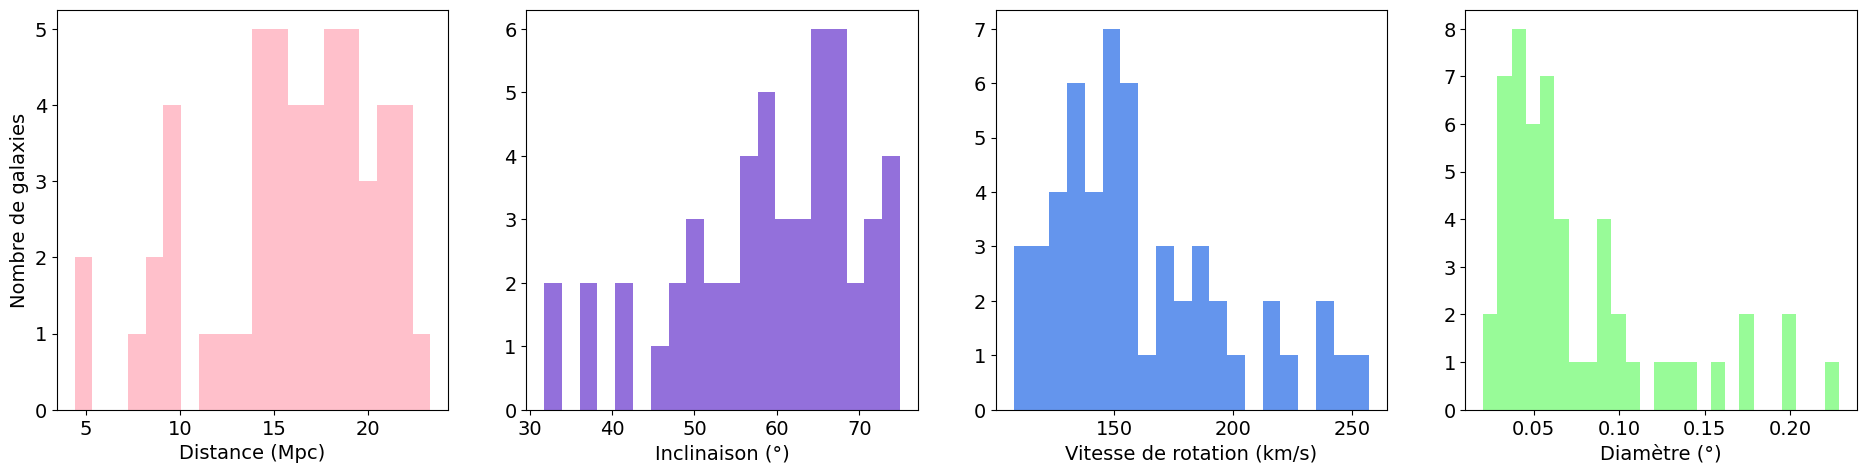

In [150]:
plt.figure(figsize = (10, 5)) 
matplotlib.rcParams.update({'font.size': 14})

plt.subplot(1,4,1)
plt.hist(donnees_finales['distance'],color='pink',ec='black',bins=20)
plt.xlabel('Distance (Mpc)')
plt.ylabel('Nombre de galaxies')

print('Statistiques pour la distance')
statistics(donnees_finales['distance'])

plt.subplot(1,4,2)
plt.hist(donnees_finales['incl'],color='mediumpurple',ec='black',bins=20)
plt.xlabel('Inclinaison (°)')

print('Statistiques pour inclinaison')
statistics(donnees_finales['incl'])


plt.subplot(1,4,3)
plt.hist(donnees_finales['vrot'],color='cornflowerblue',ec='black',bins=20)
plt.xlabel('Vitesse de rotation (km/s)')

print('Statistiques la vitesse de rotation')
statistics(donnees_finales['vrot'])

plt.subplot(1,4,4)
plt.hist((donnees_finales['diameter']), color='palegreen',ec='black',bins=25)
plt.xlabel('Diamètre (°)')

print('Statistiques le diamètre')
statistics(donnees_finales['diameter'])


plt.gcf().subplots_adjust(left = 0.2, bottom = 0.1, right = 2, top = 0.9, wspace = 0.2, hspace = 0.2)


Statistiques pour masse stellaire
-------------------------------------------------------------------------------------------
mean= 28505559131.209797
median= 20272102485.711292
standard deviation= 20857928603.53154
-1 sigma= 7476917287.129398
1 sigma= 29850103068.866413
-------------------------------------------------------------------------------------------
Statistiques pour SFR W4
-------------------------------------------------------------------------------------------
mean= 1.2505508895509965
median= 0.8205323065255954
standard deviation= 1.1906010048168247
-1 sigma= 0.396034822251746
1 sigma= 1.4374395632129284
-------------------------------------------------------------------------------------------
Statistiques pour SFR FUV
-------------------------------------------------------------------------------------------
mean= 0.16771144810577301
median= 0.12396322406643696
standard deviation= 0.14569444306484727
-1 sigma= 0.07552061557502876
1 sigma= 0.14969588144454293
---------

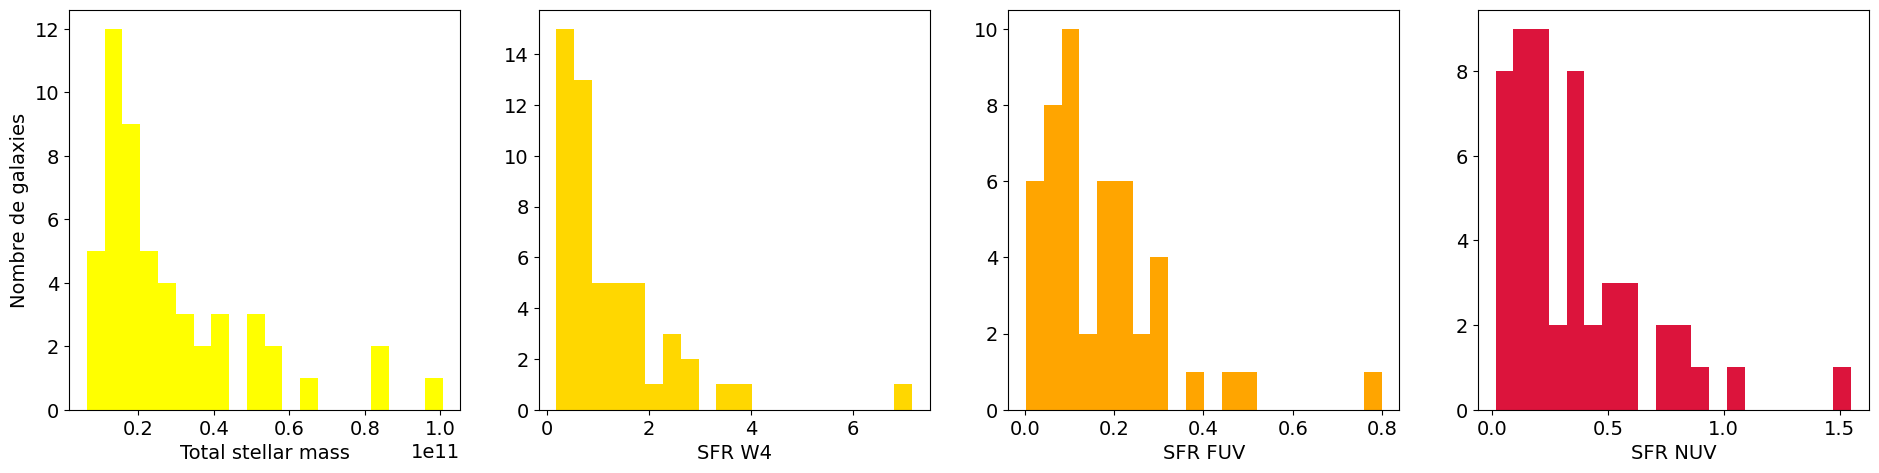

In [151]:
plt.figure(figsize = (10, 5)) 


plt.subplot(1,4,1)
plt.hist((donnees_finales['Mass']),color='yellow',ec='black',bins=20)
plt.xlabel('Total stellar mass')
plt.ylabel('Nombre de galaxies')

print('Statistiques pour masse stellaire')
statistics(donnees_finales['Mass'])

plt.subplot(1,4,2)
plt.hist((donnees_finales['SFR W4']), color='gold',ec='black',bins=20)
plt.xlabel('SFR W4')

print('Statistiques pour SFR W4')
statistics(donnees_finales['SFR W4'])


plt.subplot(1,4,3)
plt.hist(((donnees_finales['SFR FUV'])),color='orange',ec='black',bins=20)
plt.xlabel('SFR FUV')

print('Statistiques pour SFR FUV')
statistics(donnees_finales['SFR FUV'][~np.isnan(donnees_finales['SFR FUV'])])

plt.subplot(1,4,4)
plt.hist(((donnees_finales['SFR NUV'])),color='crimson',ec='black',bins=20)
plt.xlabel('SFR NUV')

print('Statistiques pour SFR NUV')
statistics(donnees_finales['SFR NUV'][~np.isnan(donnees_finales['SFR NUV'])])




plt.gcf().subplots_adjust(left = 0.2, bottom = 0.1, right = 2, top = 0.9, wspace = 0.2, hspace = 0.3)


C:\Users\valen\AppData\Local\Temp\ipykernel_6348\2801903898.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  ax.plot(donnees_finales['RA']*2*np.pi/24,donnees_finales['distance'],"r.", color = 'salmon')


Text(0.0, 1.1, 'Distance (Mpc) vs. R.A.')

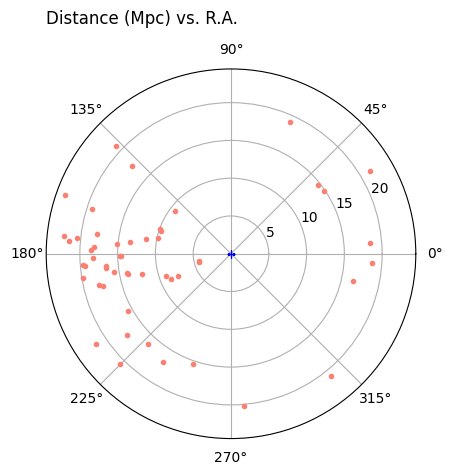

In [152]:
# Graphe polaire
matplotlib.rcParams.update({'font.size': 10})
#plot polar axis
fig,ax=plt.subplots(subplot_kw={'projection': 'polar'})

#plot Table values
#arg1 : hours to degree / arg2 : mag to Mpc

ax.plot(donnees_finales['RA']*2*np.pi/24,donnees_finales['distance'],"r.", color = 'salmon')
ax.plot(0,0,"b+")
ax.set_title('Distance (Mpc) vs. R.A.',loc='left',y=1.1)
#plt.savefig("Celestial_Position.png")